## Project 2

# SKRIV INTRO HER

In [1]:
# import necessary files 
import lanczos_bidiag as lanczos
from Helper_functions import *
import numpy as np
import matplotlib.pyplot as plt

We start by implementing the Lanczos bidiagonalization algorithm, allowing for both with and without re-orthogonalization of our column-vectors. To test this implementation, we consider three randomly generated square matrices $A_1$, $A_2$ and $A_3$, all of different sizes: 

In [3]:
## Generate test-matrices

A1 = np.random.rand(4,4)
A2 = 5 * np.random.rand(20,20)
A3 = -3 * np.random.rand(100,100)

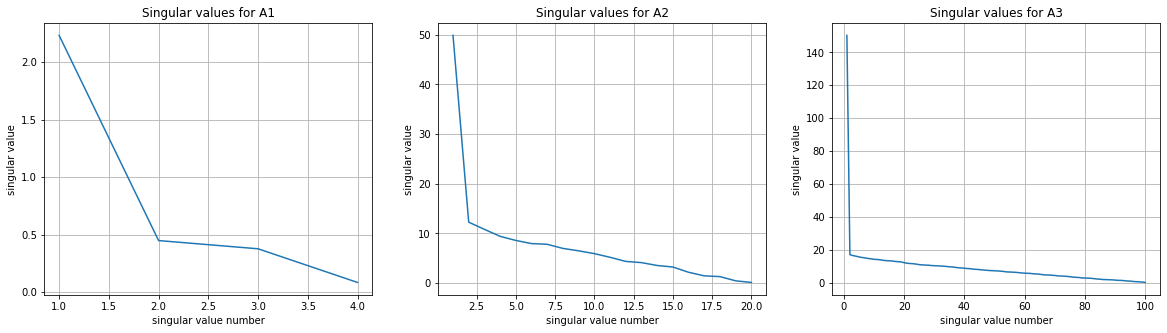

In [3]:
lanczos.plotSingularValues(A1,A2,A3)

## Skriv kort diskusjon av plots over her


Having done so, we now wish to test out our implementation of finding a k-rank approximation through Lanczos bidiagonalization algortithm, and compare it to a SVD decomposition of our matrix. We here use $A_3$ as defined above as the matrix which is to be approximated. Having calculated the approximation, we then take Frobenius norm of the difference between $A_2$ and our approximations, and plot these for each value of $k$. 

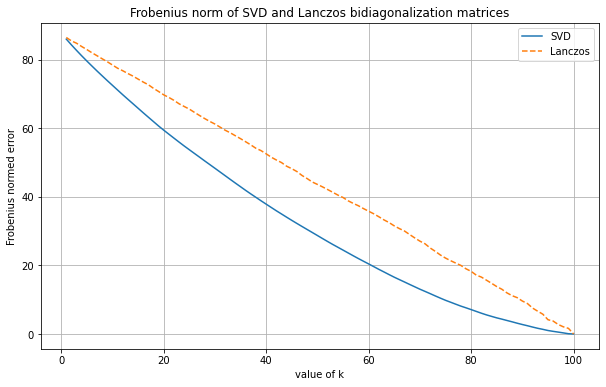

In [4]:
b = np.ones(100)
lanczos.compareApproximations(A3,b)

# Diskuter plot over

Lastly, we compare the rounding errors  of  our implementation of lanczos bidiagonalization with and without re-orthogonalization, to see if re-orthogonalizing really is necessary. The error is measured as  the sum of the 2-norm of the dot-product of the column-vectors in P and Q respectively. We use the previously defined matrix $A_3$ and the right hand side $b$ as before.

In [5]:
lanczos.orthogonalityError(A3,b)

Without re-orthogonalization: 
Mean error for P:  1.083e-01   Mean error for Q:  1.084e-01
With re-orthogonalization: 
Mean error for P:  6.912e-13  Mean error for Q:  1.944e-14


Clearly, the re-orthogonalization greatly reduces the propagation of rounding errors in our algorithm.

# rank k approximation to heat equation

The heat equation can be written on the following form.

\begin{equation}

u_t = Au + uA \  \textrm{where } A = 

\begin{bmatrix}
-2 & 1 & \dots  & 0\\
1 & -2 & \dots & \vdots \\
\vdots & \vdots & \ddots \\
0 & 0 & \dots & -2
\end{bmatrix}

\end{equation}

we wish to solve a rank k approximation to this differation equation.

We start off by solving the system for an arbitrary k, we choose to use k = 10 as it is not so small as to lose too much information, while still being able to reap the benefits of lower ranks.

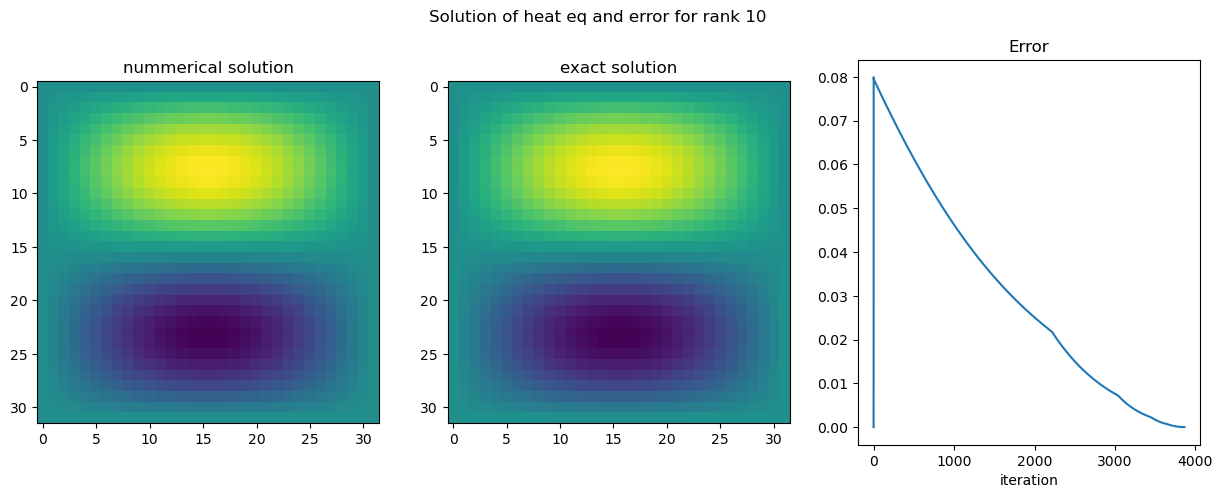

In [4]:
tol = 1.e-5
tf = 0.2
h0 = 0.1 
k = 10 

Yt,_,_,u_ex_t,error,t_vals = solve_heat_eq(k,h0,tf,tol)
plot_heat_sol_and_error(k,Yt,u_ex_t,error)

The numerical solution and the exact solution appear to be indistinguishable, and the error is decreasing for each iteration.

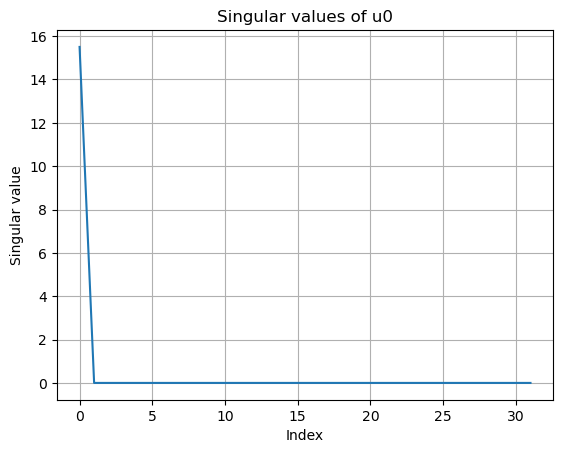

In [4]:
t0 = 0
N = 32

# Initialize u and u_dot
m,n = N,N
u0 = tilr.u_fun(g,m,n) 
S_0 = np.linalg.svd(u0)[1]
plt.plot(S_0)
plt.title('Singular values of u0')
plt.xlabel('Index')
plt.ylabel('Singular value')
plt.grid()
plt.show()

Here we have a plot of the Singular values, and it seems we only have one significant Singular value. We can exploit this and choose k to be one. This is favorable as it is more economical computationally. We will check if we are still able to extract the same solution. 

# Solving with K = 1

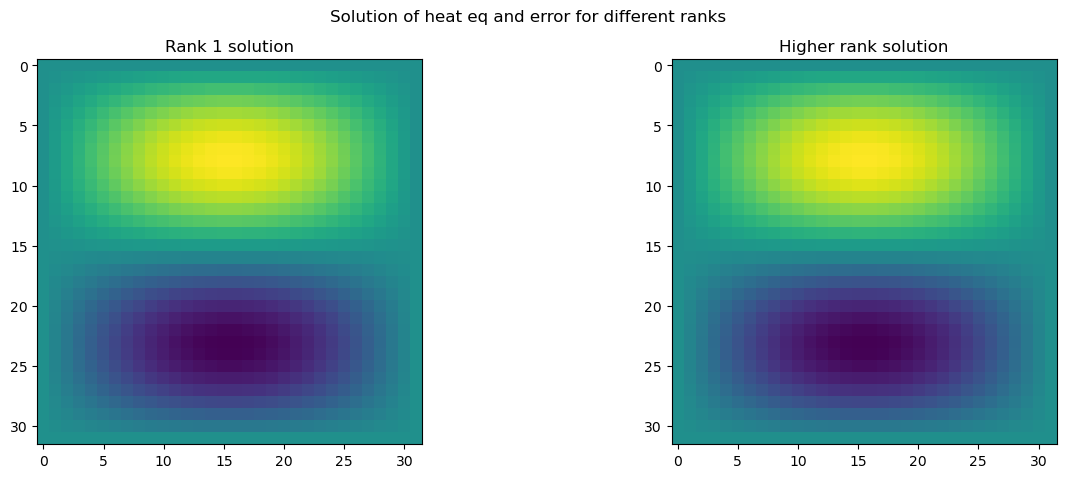

In [4]:
tol = 1.e-5
tf = 0.2
h0 = 0.1 # initial step size in vssi
k = 1 # k-rank approx

Ytk1,Ut,Vt,u_ex_tk1,error,t_vals = solve_heat_eq(k,h0,tf,tol)
plot_heat_diff_ranks(Ytk1,Yt)

There is no visible difference in the two plots. This indicates that as long as the significant singular values are included, one can expect good results. This is an especially interesting result as one can save a lot of computational effort as long as the rank of the matrix is smaller than the size.

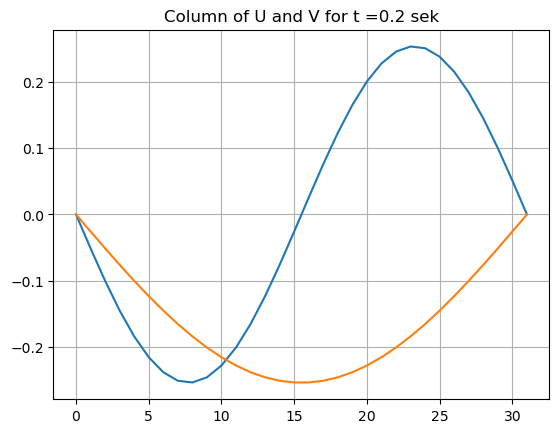

In [12]:
plt.title(f'Column of U and V for t ={tf} sek')
plt.plot(Ut[-1,:,0],label='U')
plt.plot(Vt[-1,:,0],label='V')
plt.plot()
plt.grid()
plt.show()

These results are intesting as they look like the two diffrent factors of g, with $g = sin(\pi x)sin(2 \pi x)$

moving on to a more interesting/complicated example 
we wish to solve the differation equation 

$$\frac{dA(t)}{dt} = ( \ Q_1(t)(A_1 + e^{t} A_2)Q^T_2(t) \ )' \ \textrm{with} \ Q'_i = T_i Q_i \quad \text{for } i = 1,2 $$
while 

$$
T_1 := \begin{bmatrix}
0 & -1 & \cdots & 1 \\
1 & 0 & \cdots & -1 \\
\vdots & \vdots & \ddots & \vdots \\
-1 & 1 & \cdots & 0 \\
\end{bmatrix}

\ \textrm{and} \ \

T_2 := \begin{bmatrix}
0 & -\frac{1}{2} & -1 & \cdots & 0 \\
\frac{1}{2} & 0 & \ddots & \ddots &\vdots \\
1 & \ddots & \ddots & \ddots & -1 \\
\vdots & \ddots & \ddots & \ddots & -\frac{1}{2} \\
0 & \dots & 1 & \frac{1}{2} & 0 \\
\end{bmatrix}

$$



In [3]:
tol = 1.e-3
t0 = 0
tf = 0.2
h0 = 0.1 # initial step size in vssi

Yt,Xt,Yt_dot,Wt,t_vals1 = solve_task4(10,ex.A,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals1,Xt,Yt,ex.A,Yt_dot,ex.A_dot,Wt)
norm_array1 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

Yt,Xt,Yt_dot,Wt,t_vals2 = solve_task4(20,ex.A,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals2,Xt,Yt,ex.A,Yt_dot,ex.A_dot,Wt)
norm_array2 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

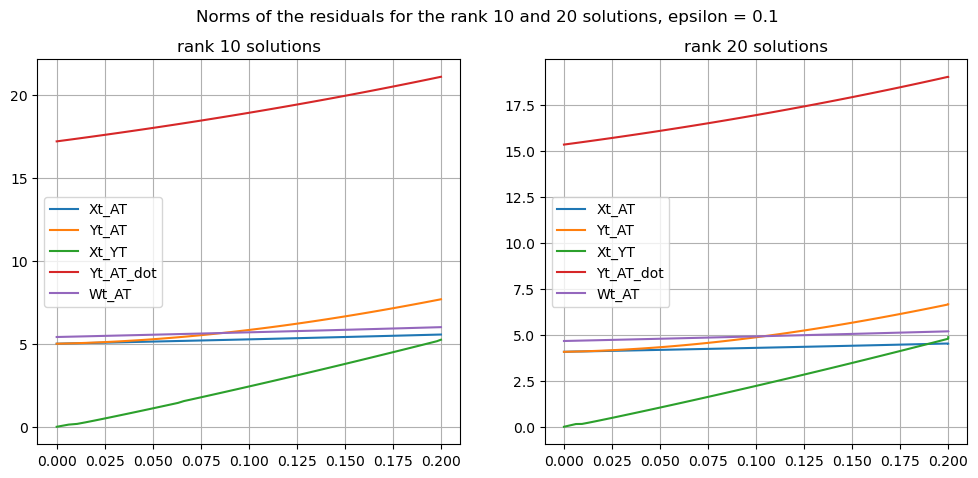

In [4]:
plot_norms(t_vals1,t_vals2,norm_array1,norm_array2,10**-1)

In [12]:
tol = 1.e-3
t0 = 0
tf = 0.2
h0 = 0.1 # initial step size in vssi

Yt,Xt,Yt_dot,Wt,t_vals1 = solve_task4(10,ex.A_3,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals1,Xt,Yt,ex.A_3,Yt_dot,ex.A_3_dot,Wt)
norm_array1 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

Yt,Xt,Yt_dot,Wt,t_vals2 = solve_task4(20,ex.A_3,h0,tf,tol)
Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT = compute_nomrs(t_vals2,Xt,Yt,ex.A_3,Yt_dot,ex.A_3_dot,Wt)
norm_array2 = [Xt_AT,Yt_AT,Xt_YT,Yt_AT_dot,Wt_AT]

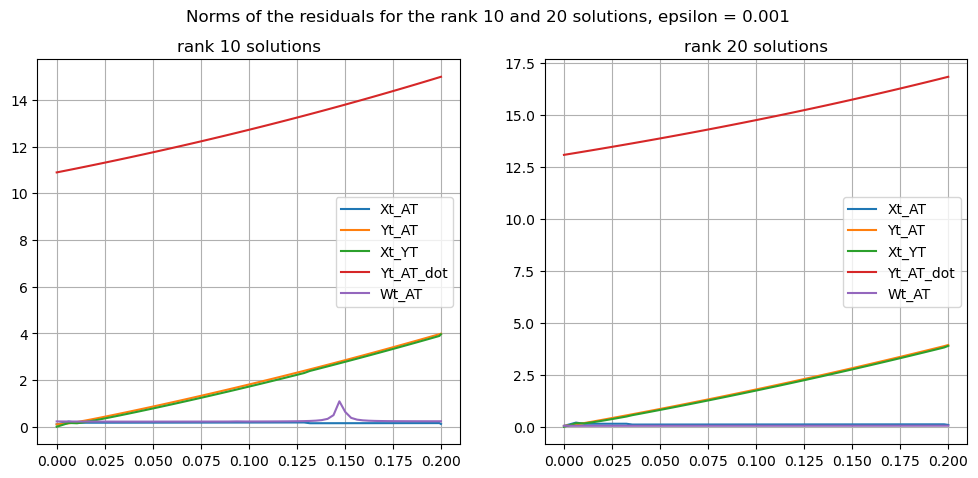

In [14]:
plot_norms(t_vals1,t_vals2,norm_array1,norm_array2,10**-3)

comment the results